In [1]:
using Gadfly, DataFrames

In [2]:
function imitate(nodes::Int, prob::Float64, moved::Int)
    tot = 0
    for i in 1:(nodes - moved)
        for j in 1:moved
            if prob > rand() 
                tot = tot + 1 
                break
            end 
        end
    end
    tot
end

imitate (generic function with 1 method)

Suppose we have $n$ nodes and $m$ moved. We wish to determine how many nodes will imitate at least one of the $m$ nodes and move themselves. Each node will imitate with probability $p$. The number of nodes available to imitate is $k = n - m$. We can think of each of these $k$ nodes as having $m$ chances to imitate a node that moved:

\begin{equation*}
  X \sim\binom{m}{x}p^x(1-p)^{m-x}
\end{equation*}

A node moves if it imitated at least one of the other nodes:

\begin{equation*}
  P(X \geq 1) = 1 - P(X < 1) = 1 - (1-p)^m = z
\end{equation*}

where $z$ is the probability a node moves. The distribution representing the probability that $v$ nodes move is given by:

\begin{equation*}
    V \sim \binom{k}{v}z^v(1-z)^{k-v}
\end{equation*}

Thus we can determine the expected number of nodes that will move:

\begin{equation}
  \langle V \rangle = k - k(1 - p)^m
  \label{eq:expv}
\end{equation}

In [3]:
function expectedMoves(n::Int, p::Float64, m::Int)
    k = n - m
    k - k * (1 - p)^m
end

expectedMoves (generic function with 1 method)

In [4]:
function expectedMovesSim(n::Int, p::Float64, m::Int, trials::Int)
    im = 0
    for i in 1:trials
        im = im + imitate(n, p, m)
    end
    im / trials
end

expectedMovesSim (generic function with 1 method)

In [5]:
n = 10
p = .5
m = 5
expectedMoves(n, p, m)

4.84375

In [6]:
expectedMovesSim(n, p, m, 10^6)

4.843425

In [7]:
function catalyze(nodes::Int, prob::Float64, moved::Int, limit::Int = 10^4; force = true)
    record = [1]
    itr = 1
    while moved > 0 && itr < limit
        moved = imitate(nodes, prob, moved)
        push!(record, moved)
        if force && moved == 0
            moved = 1
        end
        itr = itr + 1
    end
    record
end

catalyze (generic function with 2 methods)

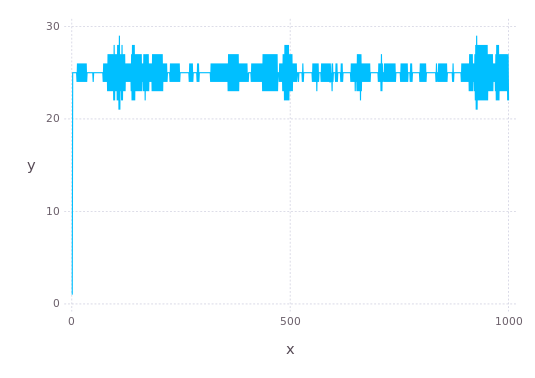

In [8]:
record = catalyze(50, .2, 3, 10^3, force = false);
mean(record);
plot(x = [x for x = 1:length(record)], y = record, Geom.line)

In [9]:
function simulate(folds::Int, totalnodes::Int, numprobs::Int, probstop::Float64)
    analysisnodes::Int = totalnodes - 1
    allmoves = Array{Float64}(analysisnodes, numprobs)
    alltime = Array{Float64}(analysisnodes, numprobs)
    probs = linspace(.01, probstop, numprobs)
    a = 1
    for p in probs, i in 2:totalnodes
        avgmoves = 0
        avgtime = 0
        for j in 1:folds
            record = catalyze(i, p, 1)
            avgmoves = avgmoves + (mean(record))
            avgtime = avgtime + length(record)
        end
        allmoves[a] = avgmoves / folds
        alltime[a] = avgtime / folds
        #print("|$i, $p: $(allmoves[a])")
        a = a + 1
    end
    (allmoves, alltime)
end

simulate (generic function with 1 method)

In [10]:
folds = 10
nodes = 30 
probs = 10
probstop = .99
probvalues = linspace(.01, probstop, probs)
(moves, time) = simulate(folds, nodes, probs, probstop);

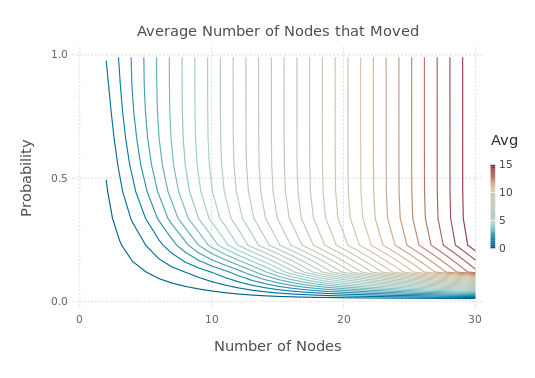

In [11]:
plot(z = moves, x = [x for x = 2:nodes], y = [x for x in probvalues],
Geom.contour(levels=30), Guide.xlabel("Number of Nodes"), Guide.ylabel("Probability"),
Guide.title("Average Number of Nodes that Moved"), Guide.colorkey("Avg"))

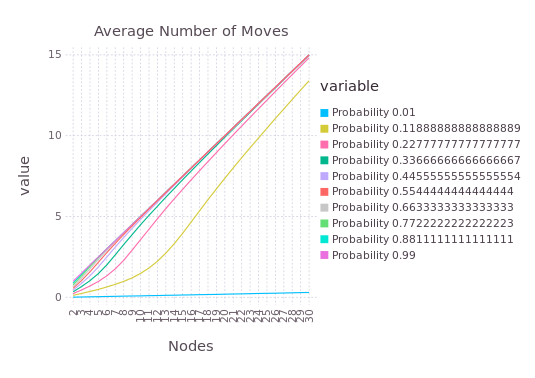

 in depwarn at deprecated.jl:73
 in oldstyle_vcat_warning at ./abstractarray.jl:29
 in vect at abstractarray.jl:38
 in anonymous at no file
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/cfusting/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/cfusting/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading In[12], in expression starting on line 2


In [12]:
data = DataFrame([2:nodes moves])
names!(data, convert(Array{Symbol, 1}, ["Nodes", [symbol("Probability $x") for x in probvalues]]))
dat = stack(data, [2:probs + 1]);
plot(dat, x = "Nodes", y = "value", color = "variable", Geom.line,
Guide.title("Average Number of Moves"), Stat.xticks(ticks = [x for x = 2:nodes]))

Consider a network with weights $w \in A = [0,1)$ representing the probability of imitation.

In [433]:
using Gadfly

In [434]:
using LightGraphs, StatsBase

In [435]:
"""
With probabilty of connection `p` generate a random symmetric adjacency matrix of uniformly 
distributed weights between 0 and 1.
"""
function randomweights(n, p, divider) 
    W = zeros(n, n)
    for i in 1:n
        W[i,i] = 0
        for j in i+1:n
            if p > rand()
                r = rand() / divider
                W[i,j] = r
                W[j,i] = r
            end
        end
    end
    W
end

randomweights (generic function with 1 method)

In [436]:
"""
With probabilty of connection `p` create a symmetric adjacency matrix of weights of weight 
`w`.
"""
function staticweights(n, p, w)
    W = zeros(n, n)
    for i in 1:n, j in i+1:n
        if p > rand()
            W[i,j] = w
            W[j,i] = w
        end
    end
    W
end

staticweights (generic function with 1 method)

Archetypes

In [437]:
"""
Get a fully connected network of `n` nodes.
"""
function getperfect(n::Int, p::Float64)
    W = zeros(n, n)
    for i in 1:n
        for j in i+1:n
            W[i,j] = p
            W[j,i] = p
        end
    end
    W
end

getperfect (generic function with 1 method)

In [438]:
getperfect(3,1.0)

3x3 Array{Float64,2}:
 0.0  1.0  1.0
 1.0  0.0  1.0
 1.0  1.0  0.0

In [439]:
"""
Changes the probabalistic weight of the edge between two nodes.
"""
function tenth(W, i, j; strengthen = true)
    if strengthen
        p = W[i,j] + 1/10 * (1 - W[i,j])
    else
        p = W[i,j] - 1/10 * W[i,j]
    end
    #print("New distance $dist\n")
    W[i,j] = p
    W[j,i] = p
end

tenth (generic function with 1 method)

In [440]:
"""
Given a symmetric weight matrix `W`, an ordered set of nodes that moved in the previous 
timestep, and a metric defining how to adjust the weights (when `dynamic = true`) evaluate
and return an ordered set of nodes that moved and adjust the weights of `W` accordingly.
"""
function imitate(W, moved, metric; dynamic = true)
    #print("Nodes moved $moved\n")
    n = size(W, 1)
    nodes = setdiff(IntSet(1:n), moved)
    imitated = IntSet()
    for i in nodes, j in moved
        if W[i,j] > rand()
            #print("$i imitated $j\n")
            push!(imitated, i)
            if dynamic metric(W, i, j) end 
        else
            if dynamic metric(W, i, j; strengthen = false) end
        end
    end
    imitated
end

imitate (generic function with 1 method)

In [441]:
n = 6
p = 1/2
divider = 2
W = randomweights(n, p, divider)
W

6x6 Array{Float64,2}:
 0.0       0.438315   0.0       0.359252   0.0       0.0     
 0.438315  0.0        0.297322  0.0632077  0.498737  0.300386
 0.0       0.297322   0.0       0.30369    0.0       0.459224
 0.359252  0.0632077  0.30369   0.0        0.0       0.0     
 0.0       0.498737   0.0       0.0        0.0       0.0     
 0.0       0.300386   0.459224  0.0        0.0       0.0     

In [442]:
nodes = IntSet(sample(collect(1:n), 2, replace = false))

IntSet([3, 6])

In [443]:
nodes = IntSet(sample(collect(1:n), 2, replace = false))
ctr = 1
while length(nodes) > 0 && ctr < 100
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
    #print("nodes : $(length(nodes)), ctr : $ctr \n")
end
triu(W)
W

6x6 Array{Float64,2}:
 0.0       0.458579   0.0       0.235705   0.0       0.0     
 0.458579  0.0        0.215108  0.0511982  0.552608  0.197083
 0.0       0.215108   0.0       0.411347   0.0       0.442167
 0.235705  0.0511982  0.411347  0.0        0.0       0.0     
 0.0       0.552608   0.0       0.0        0.0       0.0     
 0.0       0.197083   0.442167  0.0        0.0       0.0     

In [444]:
ctr - 1

10

Things to look at:

* Components $c_i$ 
* nodes $n$
* number of nodes in $c_i \equiv n_{c_i}$
* degree $k$ 
* weights $W$
* distance $D=1-W$


1. How long does an idea bounce around $c_i$ given $k_{avg}$ and $d_{avg}$ (static and dynamic cases)?
2. How does $d_{avg}$ behave as a function of $n_{c_i}$ and $W$

In [445]:
"""
Create an undirected graph without self loops from a weigth matrix.
"""
function graphfromweights(W)
    n = size(W, 1)
    g = Graph(n)
    for i in 1:n, j in i+1:n
        if W[i,j] > 0 
            add_edge!(g, i, j)
        end
    end
    g
end

graphfromweights (generic function with 1 method)

In [446]:
n = 6
p = 1/3
w = 1/2
W = staticweights(n, p, w)

6x6 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0
 0.0  0.5  0.0  0.0  0.5  0.5
 0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0
 0.0  0.0  0.5  0.0  0.0  0.0

In [447]:
g = graphfromweights(W)

{6, 3} undirected graph

In [448]:
degree(g)

6-element Array{Int64,1}:
 0
 1
 3
 0
 1
 1

In [449]:
1 - W

6x6 Array{Float64,2}:
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.5  1.0  1.0  1.0
 1.0  0.5  1.0  1.0  0.5  0.5
 1.0  1.0  1.0  1.0  1.0  1.0
 1.0  1.0  0.5  1.0  1.0  1.0
 1.0  1.0  0.5  1.0  1.0  1.0

In [450]:
function visit(node, D, vis, counted, last = 0)
    #print("Visiting node $(node)!\n")
    dist = 0
    for i in 1:size(D, 2)
        if i != last && D[i, node] < 1 
            if !((i, node) in counted)
                push!(counted, (i, node))
                push!(counted, (node, i))
                dist = dist + D[i, node]
            end
            if !(i in vis)
                push!(vis, i)
                dist = dist + visit(i, D, vis, counted, node)
            end
        end
    end 
    dist
end

visit (generic function with 2 methods)

In [451]:
"""
Calculate the total distance between nodes connected to `node` in `W`.
"""
function distance(W, node)
    vis = IntSet()
    counted = Set()
    D = 1 - W
    n = size(D, 2)
    push!(vis, node)
    visit(node, D, vis, counted)
end

distance (generic function with 1 method)

In [452]:
connected_components(g)

3-element Array{Array{Int64,1},1}:
 [1]      
 [2,3,5,6]
 [4]      

In [453]:
distance(W, 1)

Visiting node 1!


0

In [454]:
type Component
    nodes::Array{Int}
    avgdist::Float64
    avgdeg::Float64
    size::Int
    
    Component(nodes, avgdist, avgdeg) = new(nodes, avgdist, avgdeg, length(nodes))
end

In [455]:
function calccompdist(g, W)
    res = Component[]
    coms = connected_components(g) 
    degrees = degree(g)
    for i in coms
        if length(i) > 1
            avgdeg = mean(degrees[i])
            dist = distance(W, i[1]) / length(i)
            push!(res, Component(i, dist, avgdeg))
        end
    end
    res
end

calccompdist (generic function with 1 method)

In [456]:
coms = calccompdist(g, W)

1-element Array{Component,1}:
 Component([2,3,5,6],0.375,1.5,4)

In [457]:
n = 100
p = 1/90
w = 1/2
W = staticweights(n, p, w)
g = graphfromweights(W)
coms = calccompdist(g,W)

15-element Array{Component,1}:
 Component([1,20,55,82],0.375,1.5,4)                                       
 Component([2,32,61],0.3333333333333333,1.3333333333333333,3)              
 Component([3,31],0.25,1.0,2)                                              
 Component([4,15,30,34,46,51,52,58,88,100],0.45,1.8,10)                    
 Component([5,22],0.25,1.0,2)                                              
 Component([9,26],0.25,1.0,2)                                              
 Component([10,60],0.25,1.0,2)                                             
 Component([14,27,29,39,74,84,99],0.42857142857142855,1.7142857142857142,7)
 Component([16,33,45,49,63,79,86,92],0.5,2.0,8)                            
 Component([18,23,69,77],0.375,1.5,4)                                      
 Component([19,41,47,97],0.375,1.5,4)                                      
 Component([25,28,65,67],0.375,1.5,4)                                      
 Component([36,98],0.25,1.0,2)                           

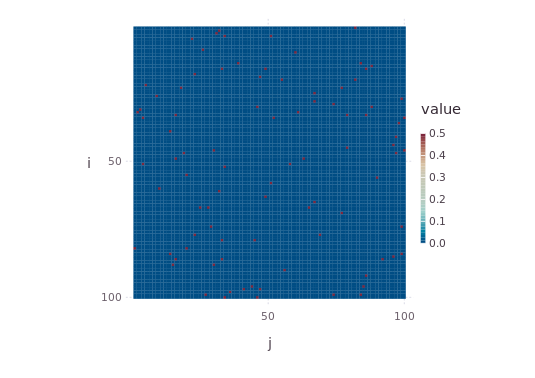

In [458]:
spy(W)

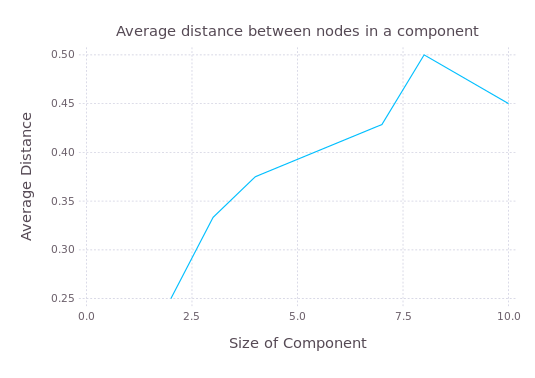

In [459]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.line)

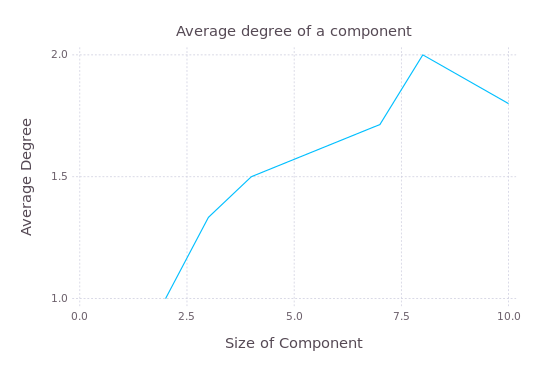

In [460]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdeg for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Degree"),
Guide.title("Average degree of a component"),
Geom.line)

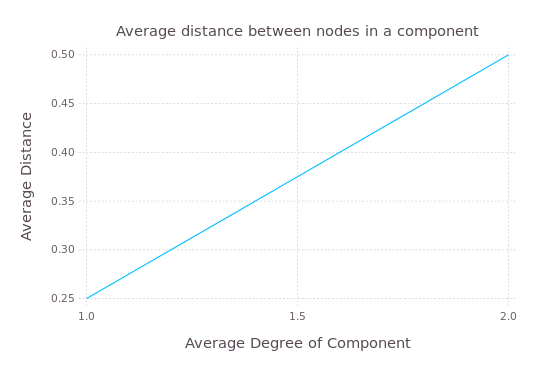

In [461]:
plot(x = [coms[i].avgdeg for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Average Degree of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.line)

In [462]:
using ProgressMeter

In [463]:
move = 10
ctr = 1
itr = 10^6
p = Progress(itr, 1)
while ctr < itr
    if length(nodes) == 0
        nodes = IntSet(sample(collect(1:n), move, replace = false))
    end
    nodes = imitate(W, nodes, tenth)
    ctr = ctr + 1
    next!(p)
end
coms = calccompdist(g, W);

Progress:  98%  ETA: 0:00:01Visiting node 1!
Visiting node 82!


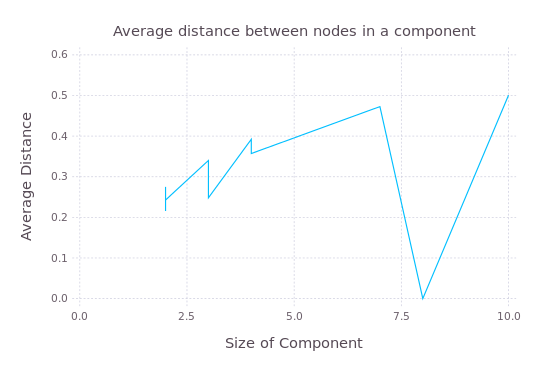

In [464]:
plot(x = [coms[i].size for i = 1:length(coms)], 
y = [coms[i].avgdist for i = 1:length(coms)], 
Guide.xlabel("Size of Component"), Guide.ylabel("Average Distance"),
Guide.title("Average distance between nodes in a component"),
Geom.line)

Visiting node 20!
Visiting node 55!
Visiting node 2!
Visiting node 32!
Visiting node 61!
Visiting node 3!
Visiting node 31!
Visiting node 4!
Visiting node 34!
Visiting node 52!
Visiting node 100!
Visiting node 46!
Visiting node 30!
Visiting node 88!
Visiting node 15!
Visiting node 51!
Visiting node 58!
Visiting node 5!
Visiting node 22!
Visiting node 9!
Visiting node 26!
Visiting node 10!
Visiting node 60!
Visiting node 14!
Visiting node 39!
Visiting node 84!
Visiting node 99!
Visiting node 27!
Visiting node 74!
Visiting node 29!
Visiting node 16!
Visiting node 33!
Visiting node 49!
Visiting node 18!
Visiting node 23!
Visiting node 77!
Visiting node 69!
Visiting node 19!
Visiting node 47!
Visiting node 97!
Visiting node 41!
Visiting node 25!
Visiting node 67!
Visiting node 28!
Visiting node 65!
Visiting node 36!
Visiting node 98!
Visiting node 44!
Visiting node 96!
Visiting node 85!
Visiting node 56!
Visiting node 90!


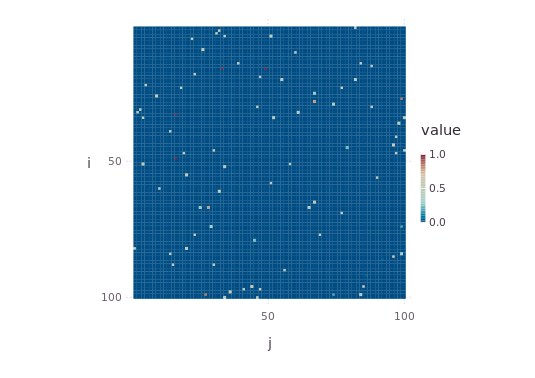

In [465]:
spy(W)

Look at the most simple case: a fully connected graph with static weights.

In [466]:
function meanweight(W)
    tot = 0.0
    ctr = 0
    for i in 1:size(W, 2), j in i+1:size(W, 1)
        tot = tot + W[i,j] 
        ctr = ctr + 1
    end
    tot / ctr
end

meanweight (generic function with 1 method)

In [480]:
function simstaticcomp(n::Int, p::Float64, move::Int = 1, ϵ = 0.001, itr::Int = 10^3)
    W = getperfect(n, p)
    dist = Float64[]
    weights = Array{Float64, 2}[] 
    p = Progress(itr, 1)
    ctr = 1
    emax = 10^2
    ectr = 1
    nodes = []
    ldist = 1
    while ctr <= itr && ectr <= emax
        if length(nodes) == 0
            nodes = IntSet(sample(collect(1:n), move, replace = false))
            #print(nodes,"\n")
        end
        nodes = imitate(W, nodes, tenth)
        push!(weights, copy(W))
        cdist = meanweight(W)
        push!(dist, cdist)
        #print("ldist: $ldist | cdist: $cdist\n")
        if abs(ldist - cdist) < ϵ
            ectr = ectr + 1
        end
        ldist = cdist
        ctr = ctr + 1
        next!(p)
    end
    (dist, weights)
end

simstaticcomp (generic function with 8 methods)

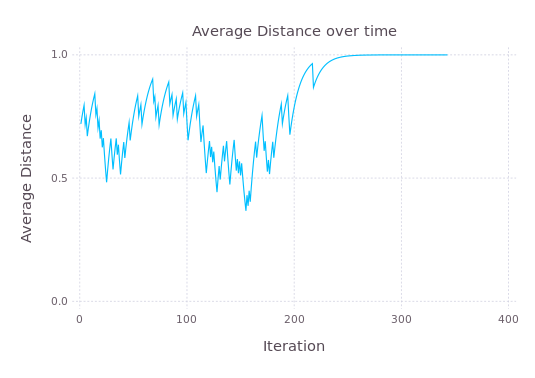

In [510]:
(dist, weights) = simstaticcomp(2, .8);
plot(x = [x for x = 1:length(dist)], 
y = [dist[i] for i = 1:length(dist)], 
Guide.xlabel("Iteration"), Guide.ylabel("Average Distance"),
Guide.title("Average Distance over time"),
Geom.line)

In [470]:
W

100x100 Array{Float64,2}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.

In [471]:
meanweight(W)

0.004070062427681606

In [518]:
function cleanweights(W, ϵ = .001)
    for i in 1:size(W, 1), j in 1:size(W, 2)
        if W[i,j] < ϵ
            W[i,j] = 0
        elseif W[i,j] > 1 - ϵ
            W[i,j] = 1
        end
    end
end

cleanweights (generic function with 2 methods)

In [519]:
function getdistmotifs(n, p, itr = 10^2)
    motifs = Set{Array{Float64, 2}}()
    for i in 1:itr
        (dist, weights) = simstaticcomp(n, p)
        W = copy(weights[end])
        cleanweights(W)
        if !(W in motifs) 
            push!(motifs, W)
        end
    end
    motifs
end

getdistmotifs (generic function with 2 methods)

In [524]:
motifs = getdistmotifs(3, .8);

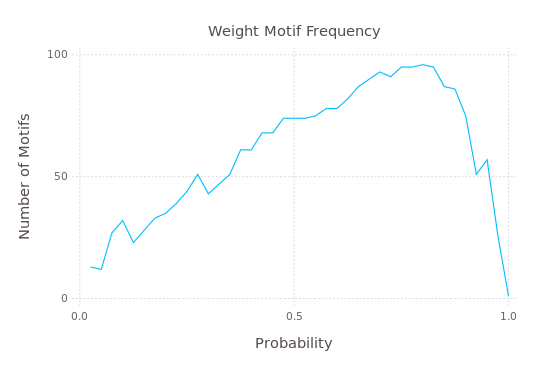

In [536]:
prob = collect(.025:.025:1)
n = 3
plot(x = [x for x in prob], y = [length(getdistmotifs(n, x)) for x in prob],
Guide.xlabel("Probability"), Guide.ylabel("Number of Motifs"),
Guide.title("Weight Motif Frequency"),
Geom.line)